# Animations
This notebook covers how to make animations
* lv.Video() arguments and basic usage
* Example: Spin and zoom
* Example: Earth spinning while showing the maximum temperature from 2000-2014

## Initial Setup

In [1]:
import datetime
import os
import numpy as np
from tqdm.notebook import tqdm
import accessvis
import xarray as xr

accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('Ultra-hig…


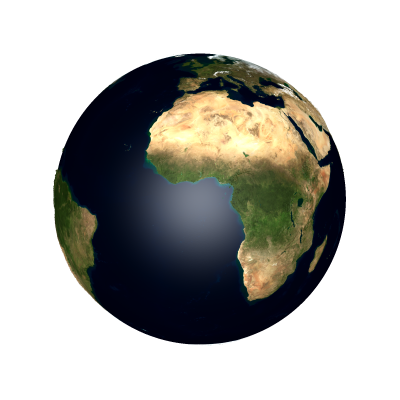

In [2]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])
lv.display((400,400))

## lv.video() Arguments and Basic Usage
The best way to create a video is with the lv.video() context manager. Here are the arguements:
* filename - The path to where it is saved.
* quality - Same options as the above resolution selector (1..4).
* resolution - Resolution of the saved video
* framerate=30 - Frames per second
* params="autoplay" - Displays the video within the notebook.
* width/height - Dimensions of the jupyter notebook video player (the video is often too big).

To create a new frame, call lv.render() within the context manager. Change the parameters between each lv.render() call and your animation will be saved.

Note that when using Jupyter notebooks, the default path may not be in the same folder as the notebook. It is recommended to specify the full path for the filename. The default folder on Gadi is typically `~/` regardless of the notebook location.

Lets look at some examples!

## Example: Spin and zoom
In the example below, we will start at (0,0), and spin the earth while zooming in onto Canberra. It is useful to call `lv.window()` and after `lv.camera()` to get appropriate translations and rotations.

Lets begin by defining start/end points.

In [3]:
num_steps = 150

lat_start = 0
lon_start = 0

lat_end = -149
lon_end = -35

start_height = -20
end_height = -7

latitudes = np.linspace(lat_start, lat_end, num_steps)
longitudes = np.linspace(lon_start, lon_end, num_steps)
heights = np.linspace(start_height, end_height, num_steps)

Now we will create the video. We will:
* Create a context manager
* Iterate through the latitudes/longitudes/heights. We use tqdm to provide a progress bar, but it is not necessary.
* Update the camera view
* Pause on the last frame for a second

Note that the file may not be saved in the same directory as the notebook.

In [4]:
filename = os.path.abspath('rotate_and_zoom.mp4')
print(filename)

with lv.video(filename=filename, quality=4, resolution=(600,600), width=600, height=600, params="autoplay") as v:
    for lat, lon, h in tqdm(zip(latitudes, longitudes, heights), total=num_steps):
        lv.reset() # Note that we must reset as rotate in this context gives a relative rotation.
        lv.rotate('y',lat)
        lv.rotate('x',lon)
        lv.translation(0, 0, h)
        
        lv.render()

    for _ in range(30): #pause at the end of the video
        lv.render()

/home/198/mp7041/rotate_and_zoom.mp4


Output #0, mp4, to '/home/198/mp7041/rotate_and_zoom.mp4':
  Stream #0:0: Unknown: none


  0%|          | 0/150 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

## Example: Annual Maximum By Year
In the example below, we will show the annual maximum temperature for each point on earth. We will animate this through time while spinning the globe.

If you are not running this notebook on Gadi, this code downloads an .nc file into an xarray object. Note that the file is ~0.5GB

The data is historical temperature at the surface from the NCI THREDDS server.

In [5]:
thredds_server = "https://thredds.nci.org.au/thredds/fileServer/fs38/publications/"
gadi_server = '/g/data/fs38/publications/'

#Temp at the surface
ver = "CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/"
fpath = "r10i1p1f1/day/tas/gn/latest/tas_day_ACCESS-ESM1-5_historical_r10i1p1f1_gn_20000101-20141231.nc"
var = 'tas'
url = f"{thredds_server}{ver}{fpath}"
gadi_path = f"{gadi_server}{ver}{fpath}"


if os.path.exists(gadi_path):
    data_file = gadi_path
else:
    print('Could not load from gadi.')
    data_file = os.path.abspath(os.path.split(url)[-1])

    if not os.path.exists(data_file):
        print(f'Downloading from {url}')
        print(f'Saving to {data_file}')
        urllib.request.urlretrieve(url, data_file)

print(f'{data_file=}')

data_file='/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/day/tas/gn/latest/tas_day_ACCESS-ESM1-5_historical_r10i1p1f1_gn_20000101-20141231.nc'


Now lets prepare the data. We will:
* Reading the data
* Taking the maximum for each year
* Plotting the result for the year 2000 as a visual check.

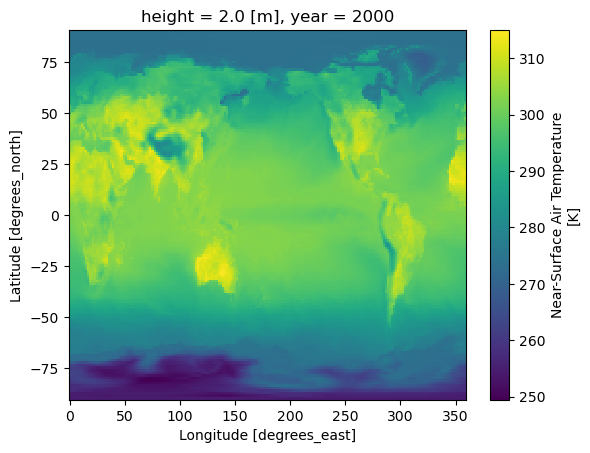

In [6]:
ds = xr.open_dataset(data_file)

yearly_maximum = ds['tas'].groupby('time.year').max(dim='time')

yearly_maximum.sel(year=2000).plot()

Now we will prepare for the animation. 
* Find the maximum and minimum across all time so we can colour the earth consistantly across time.
* Specify the location of the camera as we spin the earth 360 degrees
* Add a colourbar

In [7]:
filename = os.path.abspath('rotate_and_time_max_temp.mp4')
print(filename)

min_t = float(yearly_maximum.min())
max_t = float(yearly_maximum.max())

# Camera location
y_360 = np.linspace(0, 360, num=90, endpoint=False) # num = 30fps * 3seconds = 90
height = -20 # How zoomed the camera is.



/home/198/mp7041/rotate_and_time_max_temp.mp4


In [8]:
# If you run this multiple times, you get multiple colourbars.
colourmap='coolwarm'
cmap = lv.colourmap(colourmap, range=(min_t, max_t))
cb = lv.colourbar()

ANIMATION TIME! In the code below we iterate through each year:
* Update the colourscheme and plot the data (Note that we needed to flip our data)
* Update the title
* Render the image while spinning 360 degrees
Note that we use tqdm to provide a progress bar, but it is not necessary.

In [9]:
with lv.video(filename=filename, quality=4, resolution=(600,600), width=600, height=600, params="autoplay") as v:
    for year in tqdm(yearly_maximum.year.values):
        data = yearly_maximum.sel(year=year)
        colours = accessvis.array_to_rgba(data, colourmap=colourmap, minimum=min_t, maximum=max_t, flip=True)
        accessvis.update_earth_values(lv, dataMode=0, dataAlpha=1, data=colours)
        
        lv.title(f'Annual Maximum Temperature - {year}', fontsize=100)

        for y in y_360:
            lv.reset() # Note that we must reset as rotate in this context gives a relative rotation.
            lv.rotate('y', y)
            lv.translation(0, 0, height)
            lv.render()

  0%|          | 0/15 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>